# Introdução
A Netflix é uma plataforma de streaming que armazena uma grande quantidade de dados sobre as visualizações dos seus usuários. O processo de geração desses dados é feito por meio de uma tabela chamada ViewingActivity, que contém informações como o nome do perfil usado para assistir, a data e hora de início da visualização, a duração da sessão, entre outras.

Dentre as informações armazenadas na tabela, destaca-se o campo "Device Type", que indica o tipo de aparelho utilizado para acessar a série ou o filme. Isso permite à plataforma identificar quais dispositivos são mais utilizados pelos seus usuários para assistir conteúdo, bem como comparar a duração média das visualizações em diferentes tipos de dispositivos.

Além disso, a distribuição das visualizações por dispositivo ao longo do tempo também é analisada, permitindo à Netflix identificar se existem diferenças significativas no comportamento de uso da plataforma entre usuários que utilizam diferentes dispositivos.

Para armazenar esses dados, a Netflix utiliza bancos de dados que são projetados para atender às suas necessidades de armazenamento e análise de dados em larga escala. A tabela ViewingActivity, por exemplo, é armazenada em um banco de dados relacional que permite a realização de consultas e análises sobre as visualizações dos usuários. Além disso, a Netflix utiliza tecnologias como o Apache Cassandra para armazenar dados em grande escala e o Apache Hadoop para processamento de dados distribuído. Tudo isso é necessário para garantir que a plataforma possa processar e analisar grandes volumes de dados de maneira eficiente e escalável.

- **Dicionário de dados**:

Nome do arquivo: viewing_activity.csv

Itens de dados gerados e armazenados no projeto:

- Profile Name: o nome do perfil usado para assistir.
- Start Time: a data e a hora (UTC) do início da visualização.
- Duration: a duração da sessão.
- Attributes: esta coluna mostra detalhes adicionais das interações com o conteúdo acessado, quando disponíveis:
    - Autoplayed: user action: None: significa que o assinante não interagiu com essa série ou filme.
    - Autoplayed: user action: Unspecified: significa que o assinante interagiu com a série ou o filme (clicando na imagem da caixa e visualizando a página da série ou do filme enquanto é apresentado o conteúdo automático) ou que assistiu ao conteúdo automático por mais de 2 minutos.
    - Autoplayed: user action: User_Interaction: significa que o assinante interagiu com a série ou o filme em um navegador clicando nos controles do player ou utilizando os atalhos do teclado.
    - View was hidden: indica que a série ou filme foi marcado como “Ocultar do histórico do que foi assistido” nas configurações da conta.
    - Has branched playback: indica que o assinante pode escolher opções enquanto assiste ao título, para controlar o que acontece em seguida.
- Title: a série ou o filme assistido.
- Supplemental Video Type: vídeos que não sejam uma série ou um filme, como trailers ou montagens. A referência “N/A” significa “não se aplica”.
- Device Type: o tipo de aparelho utilizado para acessar a série ou o filme.
- Bookmark: a posição de visualização mais recente (em relação à duração total da série ou do filme) da sessão de reprodução específica de uma série ou um filme.
- Latest Bookmark: indica se o marcador é a posição de visualização mais recente (em relação à duração total da série ou do filme) na sessão de reprodução mais recente de uma série ou filme. A referência “Not latest view” indica que uma determinada sessão de reprodução não é a reprodução mais recente da série ou do filme e que, portanto, o marcador não é o mais recente.
- Country: o país de onde a série ou o filme foi assistido. Para assinantes na União Europeia que viajam por até 60 dias de um país para outros países da União Europeia, a partir de 1º de abril de 2018, este é o país em que a conta foi criada e não o país em que a série ou o filme foi assistido.
- **Considerações finais**:
    
    Além disso, falhas nos equipamentos podem ocorrer e afetar a coleta de dados. Por exemplo, pode haver problemas com a conexão à internet ou com o próprio dispositivo de medição. É importante monitorar e resolver rapidamente quaisquer problemas técnicos que possam afetar a coleta de dados.
    
    Outra questão importante é a possibilidade de viés na coleta de dados. Por exemplo, pode haver uma preferência entre os usuários por assistir a determinados tipos de conteúdo em determinados dispositivos, o que pode afetar a análise dos dados. É importante levar em consideração essas possíveis fontes de viés e tentar minimizá-las por meio de técnicas estatísticas adequadas.
    
    Em resumo, é fundamental monitorar continuamente a coleta de dados, identificar possíveis problemas e adaptar o equipamento ou a metodologia de coleta para garantir que os dados coletados sejam confiáveis e possam ser usados para tomada de decisões precisas e informadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot
import statistics
import datetime as dt
from scipy.stats import probplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.preprocessing import StandardScaler


In [2]:
df=pd.read_csv("C://Users/gabri/Untitled Folder/netflix/CONTENT_INTERACTION/ViewingActivity.csv")

In [3]:
data_group=pd.read_csv("C://Users/gabri/Untitled Folder/netflix/CONTENT_INTERACTION/data_short.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52839 entries, 0 to 52838
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Profile Name             52839 non-null  object
 1   Start Time               52839 non-null  object
 2   Duration                 52839 non-null  object
 3   Attributes               15329 non-null  object
 4   Title                    52839 non-null  object
 5   Supplemental Video Type  7911 non-null   object
 6   Device Type              50480 non-null  object
 7   Bookmark                 52839 non-null  object
 8   Latest Bookmark          52839 non-null  object
 9   Country                  52839 non-null  object
dtypes: object(10)
memory usage: 4.0+ MB


# Limpeza e tratamento dos dados:
Mudando o tipo de dados que estão incorretos.

In [23]:
top_devices = df['Device Type'].value_counts().head(10)
print(top_devices.index.tolist())

['DefaultWidevineAndroidPhone', 'LG DTV 2020 RTK K6Hp UHD TV Smart TV', 'Android DefaultWidevineL3Phone Android Phone', 'Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV', 'LG 2018 Mstar LM18A STD UHD TV Smart TV', 'Xiaomi volver Smart TV', 'Chrome PC (Cadmium)', 'LG LG 2017 MStar M2R Standard DTV Smart TV', 'Android DefaultWidevineL3Phone Android Phone (motorola_MotoG3)', 'Philips 2013 MTK5396 based TVs Smart TV']


In [5]:
def convert_duration_to_seconds(duration):
    """Converte uma string de duração no formato 'HH:MM:SS' para segundos."""
    parts = duration.split(":")
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = int(parts[2])
    return hours * 3600 + minutes * 60 + seconds
df["Duration"] = df["Duration"].apply(convert_duration_to_seconds)


# Análise exploratória e visualização dos dados:

Podemos ver que temos informações sobre o nome do perfil do usuário, o horário de início da visualização, a duração, o título do programa, o tipo de vídeo, o tipo de dispositivo, o marcador de tempo de onde a visualização parou, entre outros.

Vamos observar:

- Tempo assistido por perfil

- Tempo assistido por dispostivo

- Tempo assistido por País

- Tempo assistido por dispositivo em cada perfil

- Entendendo a distribuição dos perfis em tempo assistido nos 10 dispositivos mais utilizados.

- Duração média de tempo assistido em cada dispositivo (Entendendo em quais dispositivos temos a tendência de manter sessões mais longas)

- Distribuição das visualizações por dispositivo ao longo do tempo (Entendendo quais dispositivos não são mais utilizados)

Serão limpados valores extremamente longíquos do resto da distribuição.

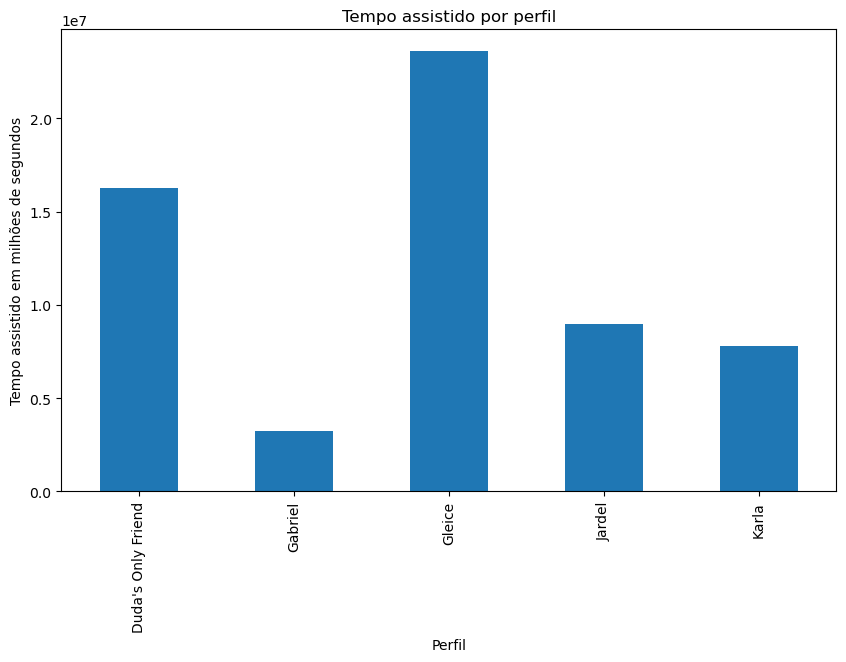

In [6]:
# converter a coluna Duration para o tipo de dados correto (float)
df["Duration"] = df["Duration"].astype(float)

# agrupar os dados por perfil e somar a duração de cada visualização
time_watched = df.groupby("Profile Name")["Duration"].sum()

# plotar o gráfico
time_watched.plot(kind="bar", figsize=(10, 6))
plt.title("Tempo assistido por perfil")
plt.xlabel("Perfil")
plt.ylabel("Tempo assistido em milhões de segundos")
plt.show()

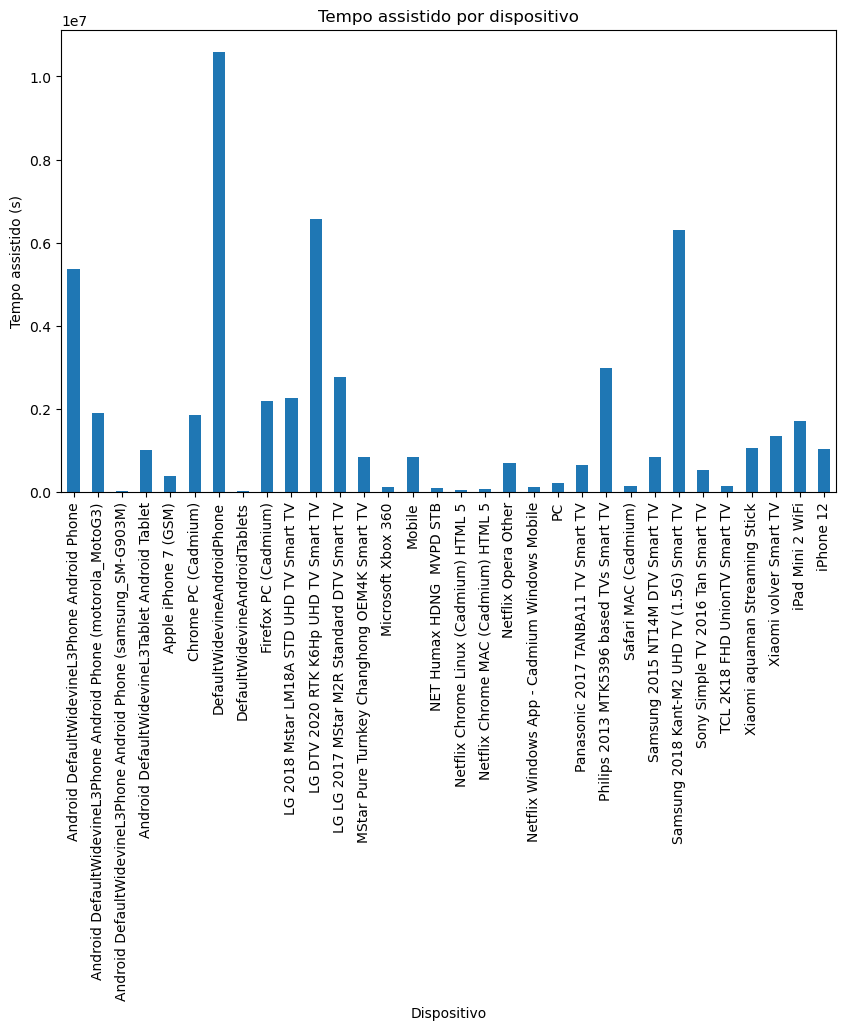

In [7]:


# agrupar os dados por dispositivo e somar a duração de cada visualização
time_watched = df.groupby("Device Type")["Duration"].sum()

# plotar o gráfico
time_watched.plot(kind="bar", figsize=(10, 6))
plt.title("Tempo assistido por dispositivo")
plt.xlabel("Dispositivo")
plt.ylabel("Tempo assistido (s)")
plt.show()

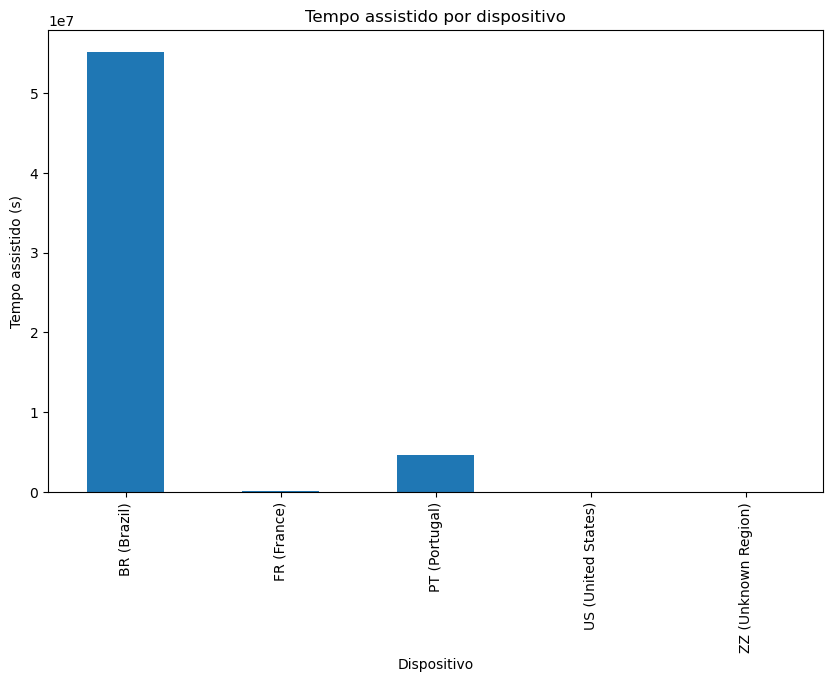

In [8]:


# agrupar os dados por dispositivo e somar a duração de cada visualização
time_watched = df.groupby("Country")["Duration"].sum()

# plotar o gráfico
time_watched.plot(kind="bar", figsize=(10, 6))
plt.title("Tempo assistido por dispositivo")
plt.xlabel("Dispositivo")
plt.ylabel("Tempo assistido (s)")
plt.show()

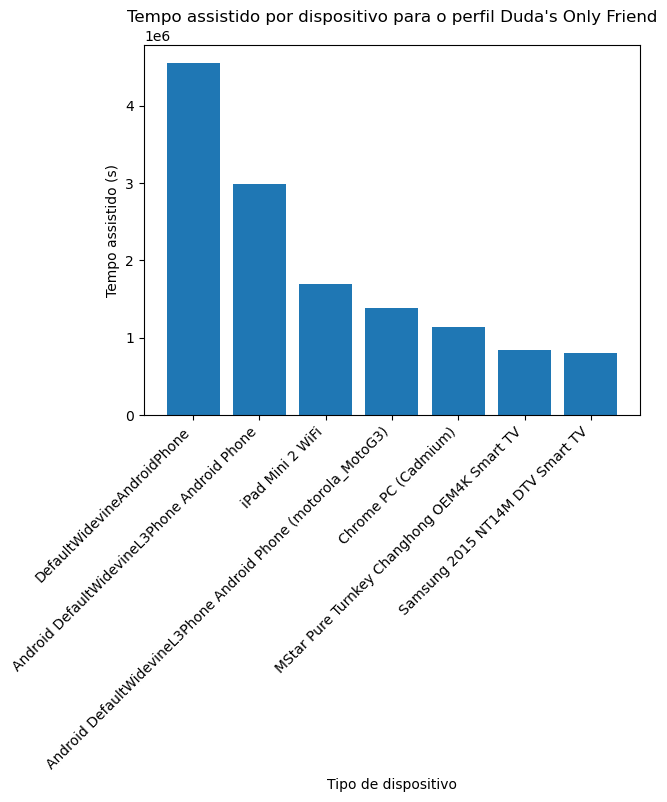

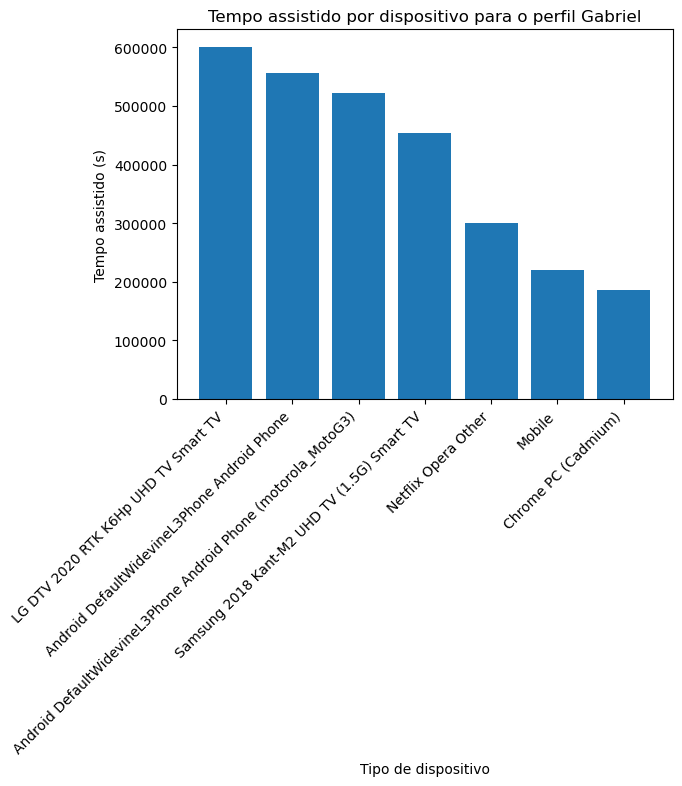

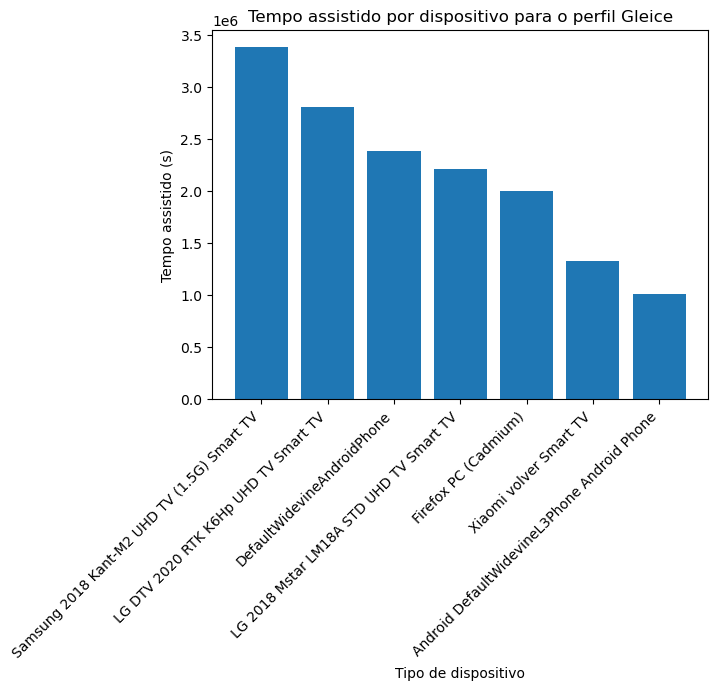

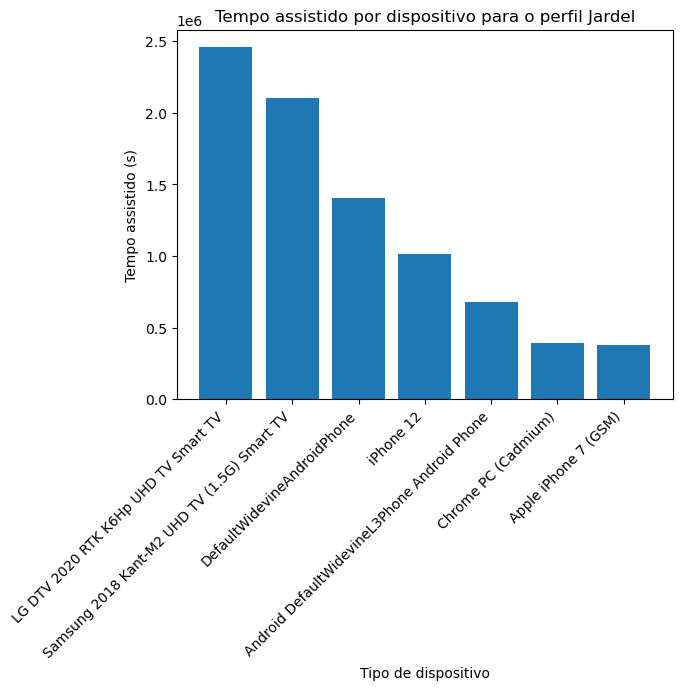

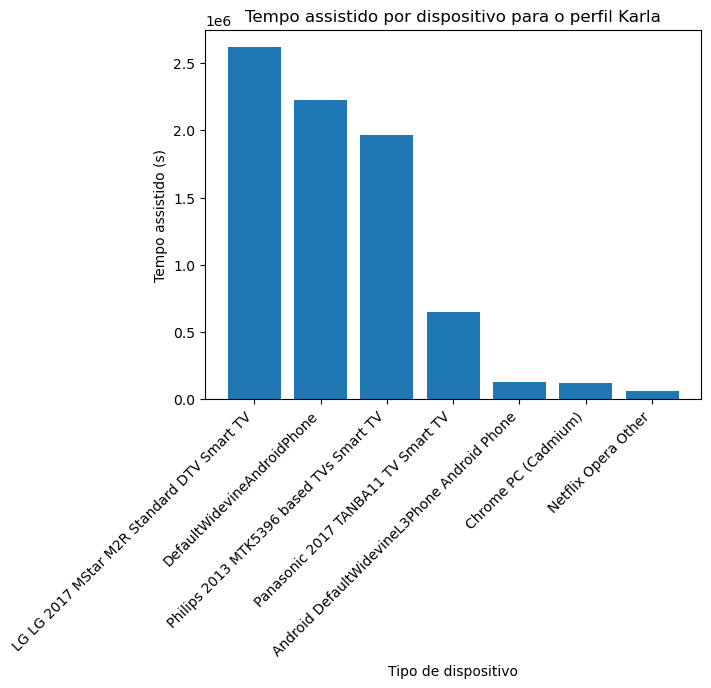

In [9]:
# Agrupa os dados por perfil e dispositivo e calcula a soma do tempo assistido
grouped = df.groupby(['Profile Name', 'Device Type'])['Duration'].agg('sum')

# Cria um gráfico de barras para cada perfil mostrando o tempo assistido em cada dispositivo
for profile in df['Profile Name'].unique():
    profile_data = grouped[profile].sort_values(ascending=False).head(7)
    plt.figure()
    plt.title(f'Tempo assistido por dispositivo para o perfil {profile}')
    plt.bar(profile_data.index, profile_data.values)
    plt.xlabel('Tipo de dispositivo')
    plt.ylabel('Tempo assistido (s)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [10]:
df.head()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Duda's Only Friend,2023-04-30 22:33:35,6538.0,NaN,Alerta Lobo,NaN,DefaultWidevineAndroidPhone,01:50:03,01:50:03,BR (Brazil)
1,Duda's Only Friend,2023-04-29 20:22:24,650.0,NaN,Sweet Tooth: Temporada 2: Balada dos Últimos H...,NaN,DefaultWidevineAndroidPhone,00:15:34,00:15:34,BR (Brazil)
2,Duda's Only Friend,2023-04-29 19:37:11,2704.0,NaN,Sweet Tooth: Temporada 2: Vou te encontrar (Ep...,NaN,DefaultWidevineAndroidPhone,00:50:41,00:50:41,BR (Brazil)
3,Duda's Only Friend,2023-04-29 19:21:55,677.0,NaN,"Sweet Tooth: Temporada 2: Início de um sonho, ...",NaN,DefaultWidevineAndroidPhone,00:39:20,00:39:20,BR (Brazil)
4,Duda's Only Friend,2023-04-29 16:44:49,167.0,NaN,"Sweet Tooth: Temporada 2: Início de um sonho, ...",NaN,DefaultWidevineAndroidPhone,00:26:01,Not latest view,BR (Brazil)


In [11]:
# separa os gêneros em três colunas
data_group = data_group.rename(columns={'primaryTitle': 'Title'})



data_group[['Genre 1', 'Genre 2', 'Genre 3']] = data_group['genres'].str.split(',', expand=True)

In [12]:
data_group

,tconst,Title,genres,Genre 1,Genre 2,Genre 3
0,tt0080217,Hana no mahoutsukai Mary Bell,"Adventure,Animation,Comedy",Adventure,Animation,Comedy
1,tt0087305,The Power of Desire,"Drama,Romance",Drama,Romance,None
2,tt0088472,An Actor's Life for Me,Comedy,Comedy,None,None
3,tt0088473,Adventures in Wonderland,"Adventure,Comedy,Family",Adventure,Comedy,Family
4,tt0092330,Casino Royal,Comedy,Comedy,None,None
...,...,...,...,...,...,...
173562,tt9916206,Nojor,Fantasy,Fantasy,None,None
173563,tt9916216,Kalyanam Mudhal Kadhal Varai,Romance,Romance,None,None
173564,tt9916218,Lost in Food,Talk-Show,Talk-Show,None,None
173565,tt9916380,Meie aasta Aafrikas,"Adventure,Comedy,Family",Adventure,Comedy,Family


In [13]:
df = df.merge(data_group, on='Title', how='left')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52897 entries, 0 to 52896
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Profile Name             52897 non-null  object 
 1   Start Time               52897 non-null  object 
 2   Duration                 52897 non-null  float64
 3   Attributes               15345 non-null  object 
 4   Title                    52897 non-null  object 
 5   Supplemental Video Type  7911 non-null   object 
 6   Device Type              50536 non-null  object 
 7   Bookmark                 52897 non-null  object 
 8   Latest Bookmark          52897 non-null  object 
 9   Country                  52897 non-null  object 
 10  tconst                   253 non-null    object 
 11  genres                   253 non-null    object 
 12  Genre 1                  253 non-null    object 
 13  Genre 2                  117 non-null    object 
 14  Genre 3               

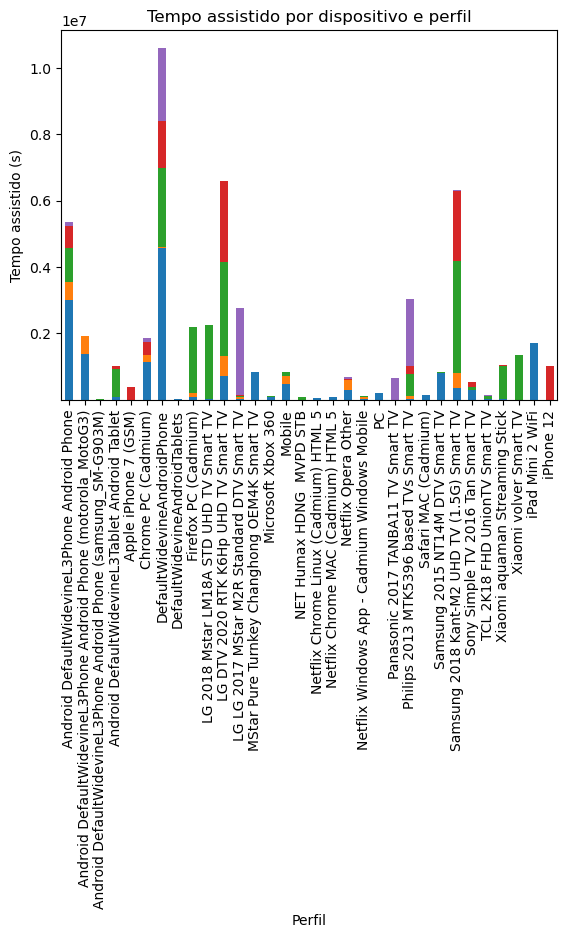

In [16]:
# Agrupar os dados por perfil e dispositivo e calcular a soma do tempo assistido
grouped = df.groupby(['Device Type','Profile Name'])['Duration'].agg('sum')

# Reorganizar os dados em um dataframe com os dispositivos como colunas
stacked = grouped.unstack()

# Criar um gráfico de barras empilhadas
stacked.plot.bar(stacked=True)

# Configurar as legendas e rótulos dos eixos
plt.title('Tempo assistido por dispositivo e perfil')
plt.xlabel('Perfil')
plt.ylabel('Tempo assistido (s)')
plt.legend().set_visible(False)
plt.show()

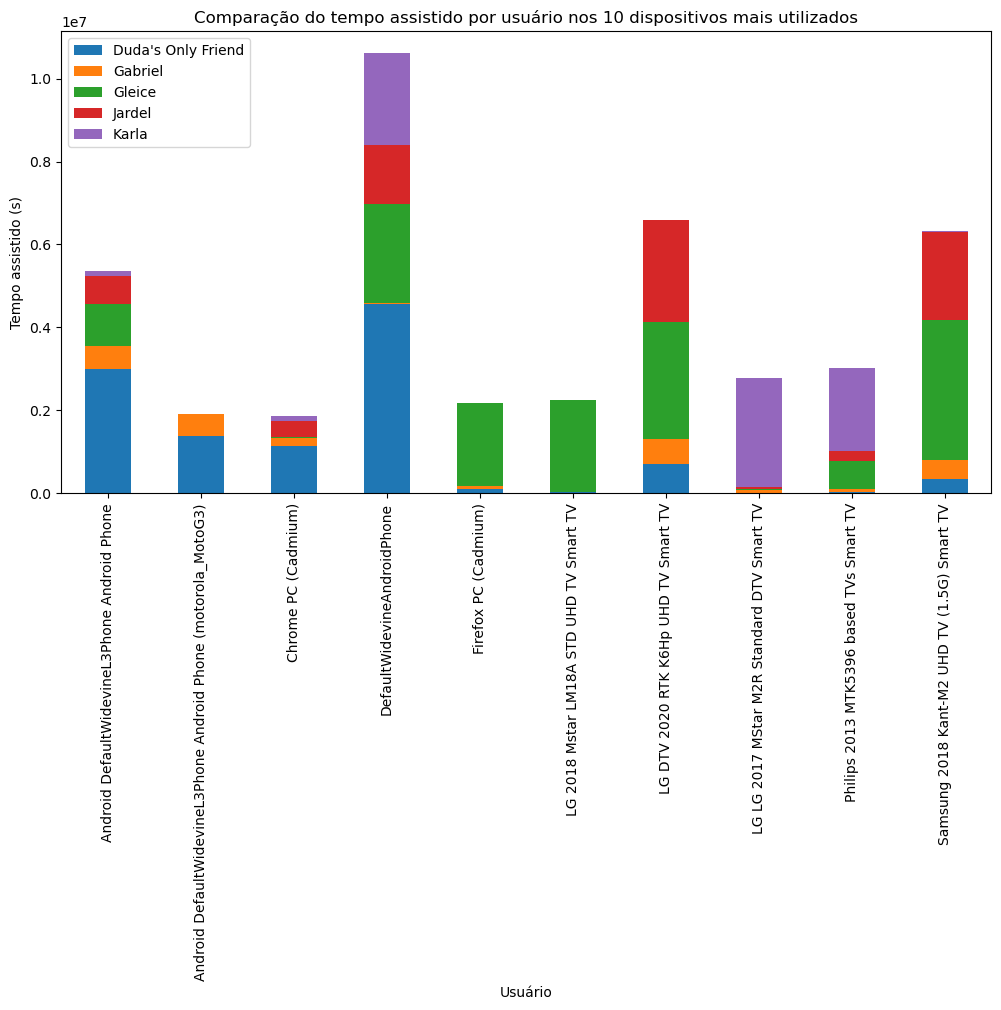

In [17]:
# Agrupa os dados por usuário e dispositivo e calcula a soma do tempo assistido
grouped = df.groupby(['Device Type', 'Profile Name'])['Duration'].agg('sum')

# Seleciona os 10 dispositivos mais utilizados
top_devices = grouped.groupby('Device Type').sum().sort_values(ascending=False).head(10).index

# Filtra os dados apenas para os dispositivos selecionados
grouped = grouped[grouped.index.get_level_values('Device Type').isin(top_devices)]

# Cria um DataFrame com os usuários como índices e os dispositivos como colunas
stacked = grouped.unstack(level=1).fillna(0)

# Plota um gráfico de barras empilhadas
stacked.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Usuário')
plt.ylabel('Tempo assistido (s)')
plt.title('Comparação do tempo assistido por usuário nos 10 dispositivos mais utilizados')
plt.legend(loc='upper left')
plt.show()

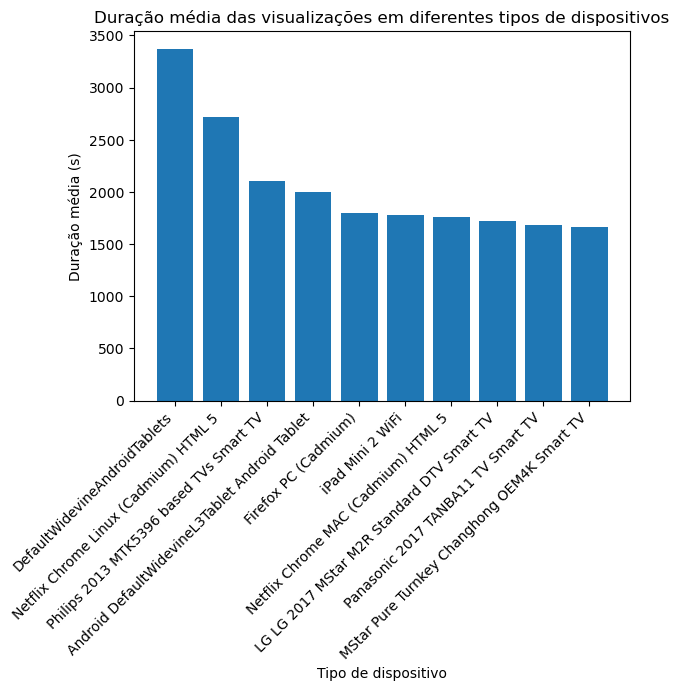

In [18]:
# Agrupa os dados por dispositivo e calcula a média do tempo assistido
grouped = df.groupby('Device Type')['Duration'].mean().sort_values(ascending=False).head(10)

# Cria um gráfico de barras mostrando a média de tempo assistido em cada dispositivo
plt.figure()
plt.title('Duração média das visualizações em diferentes tipos de dispositivos')
plt.bar(grouped.index, grouped.values)
plt.xlabel('Tipo de dispositivo')
plt.ylabel('Duração média (s)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
# Converter a coluna "Start Time" para o formato datetime e usar como índice
df['Start Time'] = pd.to_datetime(df['Start Time'])
df = df.set_index('Start Time')
df['Day'] = df.index.date


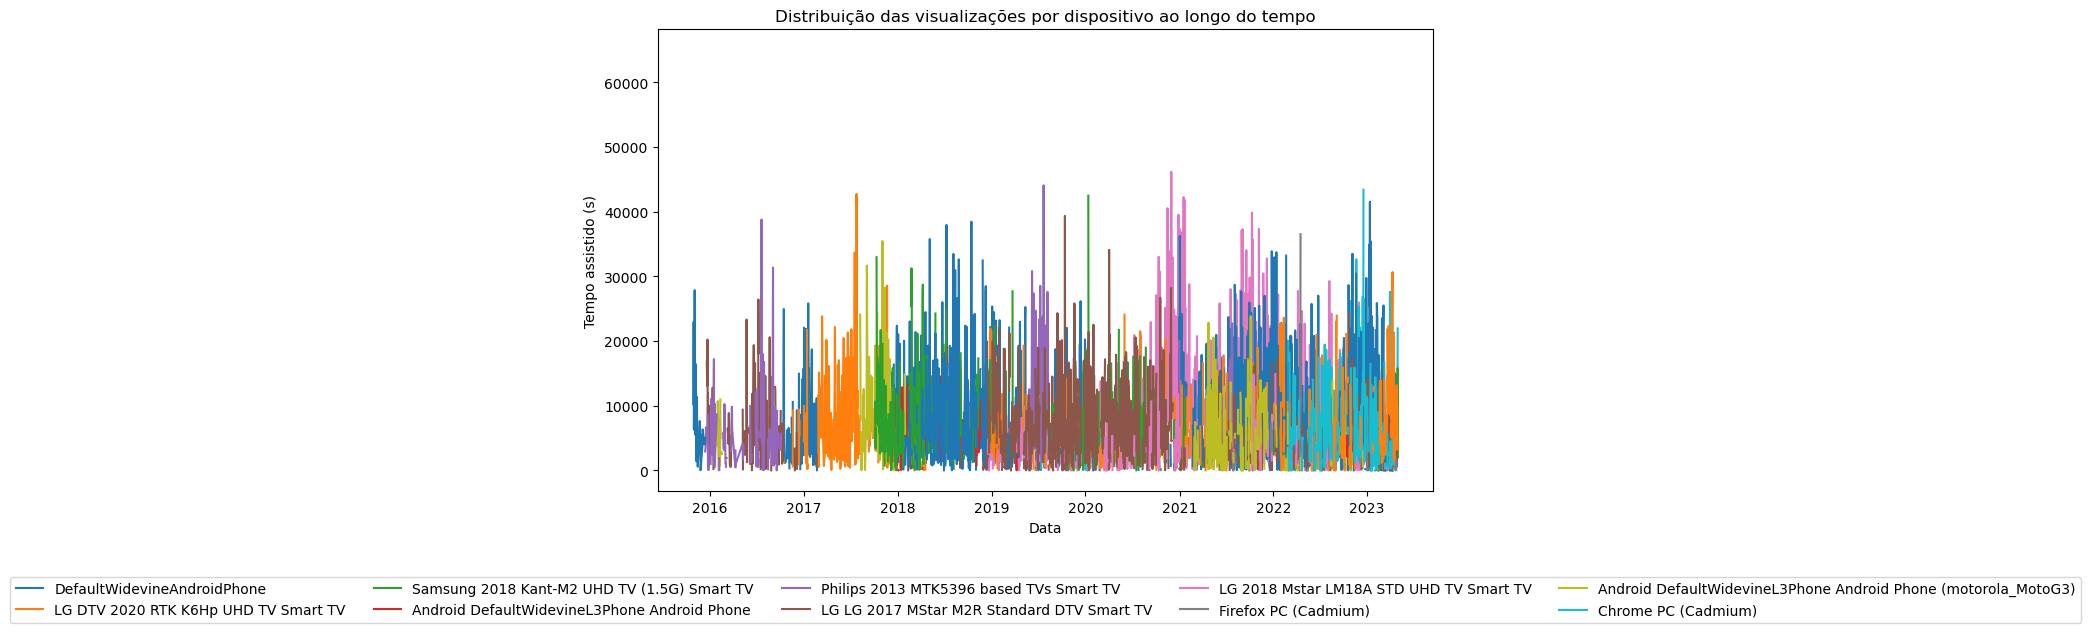

In [20]:

# Agrupar por dispositivo e dia

grouped = df.groupby(['Device Type', 'Day'])['Duration'].agg('sum')
grouped=grouped.loc[grouped < 100000]
# Criar DataFrame com os dados agrupados
data = grouped.unstack(level=0)

# Plotar gráfico de linha para cada dispositivo
data.plot(kind='line', figsize=(10, 6))

# Configurar o gráfico
plt.title('Distribuição das visualizações por dispositivo ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Tempo assistido (s)')
plt.legend(top_devices, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5)

plt.show()

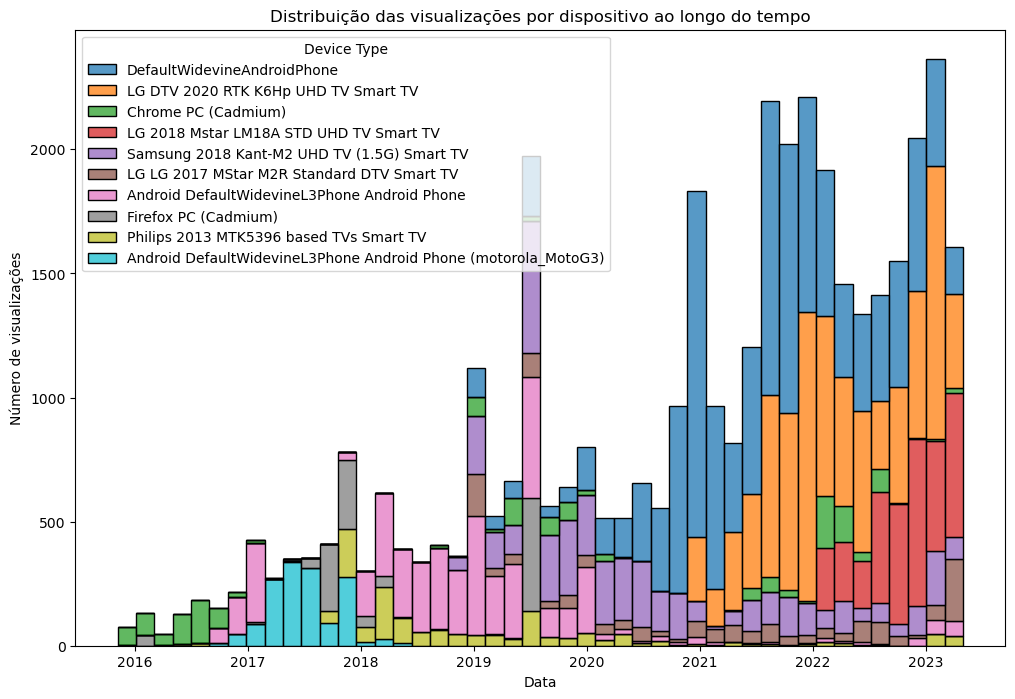

In [22]:
# Seleciona os 10 dispositivos mais utilizados ao longo do tempo
top_devices = df.groupby('Device Type')['Duration'].agg('sum').sort_values(ascending=False)[:10]
df_top_devices = df[df['Device Type'].isin(top_devices.index)]

# Plota o gráfico de distribuição das visualizações por dispositivo ao longo do tempo
plt.figure(figsize=(12,8))
sns.histplot(data=df_top_devices, x='Start Time', hue='Device Type', multiple='stack')
plt.xlabel('Data')
plt.ylabel('Número de visualizações')
plt.title('Distribuição das visualizações por dispositivo ao longo do tempo')
plt.show()

# Resultados e conclusões:
Neste projeto, foi possível identificar os dispositivos mais utilizados para assistir conteúdo na plataforma, comparar a duração média das visualizações em diferentes tipos de dispositivos, analisar a distribuição das visualizações por dispositivo ao longo do tempo e identificar diferenças significativas no comportamento de uso da plataforma entre usuários que utilizam diferentes dispositivos. Também foi analisada a relação entre o tipo de dispositivo utilizado e outras variáveis, como país, gênero ou idade dos usuários.

Por fim, é importante destacar que a análise de dados é um processo contínuo e que novas questões podem surgir à medida que novos dados são coletados e novas tecnologias são utilizadas. Por isso, é fundamental que as empresas invistam em profissionais capacitados para lidar com dados e em tecnologias que permitam a coleta e análise de dados de forma confiável e eficiente.